ANOVA for Abalone dataset

There are 3 assumptions that need to be met for the results of an ANOVA test to be considered accurate and trust worthy. It’s important to note the the assumptions apply to the residuals and not the variables themselves. The ANOVA assumptions are the same as for linear regression and are:


1.   Normality
2.   Homogeneity of variance
3.   Independent observations



Dane, które postanowiliśmy analizować to dane dotyczące uchowców. Na początek postanowiliśmy sprawdzić czy długość uchowca ma wpływ na jego płeć. Na początek wczytujemy dane i wybieramy po 1000 próbek dla każdej z płci.

In [0]:
import pandas as pd

data_url='https://raw.githubusercontent.com/codevibess/abalone-anova/master/data/abalone.data'
df = pd.read_csv(data_url)
a = df[df.Sex == "M"].head(1000)
b = df[df.Sex == 'F'].head(1000)
c = df[df.Sex == 'I'].head(1000)
df = a.append(b).append(c)

print(df)

     Sex  Length  Diameter  ...  Viscera weight  Shell weight  Rings
0      M   0.455     0.365  ...          0.1010        0.1500     15
1      M   0.350     0.265  ...          0.0485        0.0700      7
3      M   0.440     0.365  ...          0.1140        0.1550     10
8      M   0.475     0.370  ...          0.1125        0.1650      9
11     M   0.430     0.350  ...          0.0810        0.1350     10
...   ..     ...       ...  ...             ...           ...    ...
3106   I   0.300     0.220  ...          0.0260        0.0315      5
3107   I   0.370     0.275  ...          0.0505        0.0680      5
3108   I   0.375     0.285  ...          0.0400        0.0725      7
3109   I   0.380     0.290  ...          0.0465        0.0750      7
3110   I   0.395     0.300  ...          0.0680        0.0895      8

[3000 rows x 9 columns]


Następnie dzielimy dane na grupy oraz wyznaczamy ilość danych oraz ilosć w poszczególnych grupach

In [0]:
groups = pd.unique(df.Sex.values)
data = {g:df['Length'][df.Sex == g] for g in groups}

k = len(pd.unique(df.Sex))
N = len(df.values)
n1, n2, n3 = df.groupby('Sex').size()


Kolejnym krokiem jest wyznaczenie statystyki testowej F oraz wartosći p-value korzystając z biblioteki SciPy

In [0]:
#Anova korzystając z SciPy

from scipy import stats

F, p = stats.f_oneway(data['M'], data['F'], data['I'])

print("F = ",F, "prawdopodobieństwo hipotezy zerowej = ",p)

#prawdopodobieństwo hipotezy zerowej wyszło 3.0881829496997467e-232, oznacza to, że średnia długość uchowca róźni się miedzy grupami 

F =  640.2077341389622 prawdopodobieństwo hipotezy zerowej =  3.0881829496997467e-232


Koeljnym krokiem było analizy wariancji bez uzycia biblioteki SciPy

In [0]:
#teraz anova bez biblioteki
#njpierw obliczamy stopnie swobody
DFbetween = k - 1
DFwithin = N - k
DFtotal = N - 1

#suma kwadratów odchyleń pomiędzy grupami

SSbetween  = (sum(df.groupby(['Sex']).sum()['Length']**2)/n1)- (df['Length'].sum()**2)/N

#print("SSBetween: "+str(SSbetween))
#suma kwadratów odchyleń wewnątrzgrupowych
sum_y_squared = sum([value**2 for value in df['Length'].values])
SSwithin = sum_y_squared - sum(df.groupby('Sex').sum()['Length']**2)/n1
#print("SSWithin: "+str(SSwithin))
# Ogólnie
SStotal = sum_y_squared - (df['Length'].sum()**2)/N
#średnie kwadraty odchyleń
MSbetween = SSbetween/DFbetween
MSwithin = SSwithin/DFwithin

#Wartość F statystyki testowej
F = MSbetween/MSwithin

#p-value
p = stats.f.sf(F, DFbetween, DFwithin)

eta_sqrd = SSbetween/SStotal
om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)

results = {'sum_sq':[SSbetween, SSwithin],
           'df':[DFbetween, DFwithin],
           'F':[F, ''],
            'PR(>F)':[p, ''],
          'EtaSq':[eta_sqrd, ''],
          'OmegaSq':[om_sqrd, '']}

aov_table1 = pd.DataFrame(results, 
                          index=['Group', 'Residual'])
    
aov_table1


,sum_sq,df,F,PR(>F),EtaSq,OmegaSq
Group,13.191573,2,640.208,3.08818e-232,0.299343,0.298806
Residual,30.876809,2997,,,,


Następnie przeprowadzamy analizę pomiędzy poszczególnymi grupami. Analiza zostaje przeprowadzona na poziomie ufności 99%. 

In [0]:
#Teraz sprawdzimy poszczególne grupy

from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

MultiComp = MultiComparison(df['Length'],
                            df['Sex'])


print(MultiComp.tukeyhsd(0.01).summary())

#Widać na podstawie danych, że średnie miedzy poszczególnymi grupami róźnią się od siebie na poziomie ufnośći 99%

Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     F      I  -0.1513 0.001 -0.1645 -0.1381   True
     F      M  -0.0245 0.001 -0.0377 -0.0113   True
     I      M   0.1268 0.001  0.1136    0.14   True
---------------------------------------------------


Mimo tak dużego poziomu ufności widać, że możemy odrzucić hipotezę, że średnie są równe między sobą. Oznacza to, że długość uchowca doskonale określa płeć uchowca. Ponizej przedstawiamy wykresy pudełkowe dla poszczególnych płci:

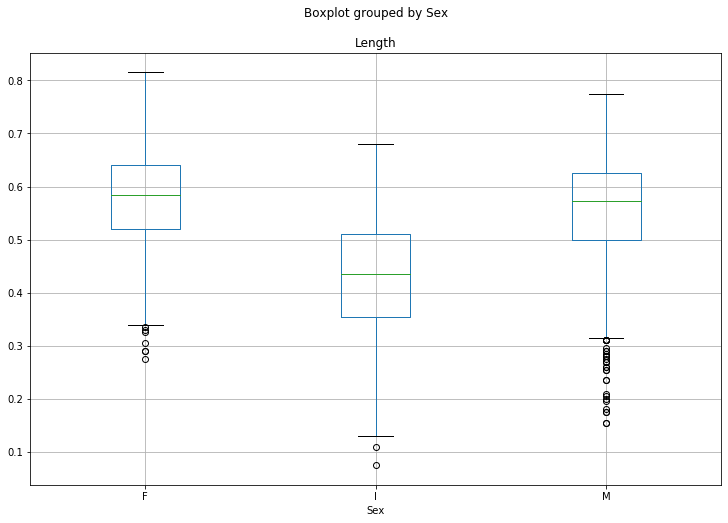

In [0]:
df.boxplot('Length', by='Sex', figsize=(12, 8))

Możemy zauważyć , że najbardziej zbliżone są do siebie płeć męska i żeńska. Ogólnie mamt też mało obserwacji nietypowych. Jednak najwięcej jest ich dla płci męskiej. Jeżeli będziemy klasyfikować płeć uchowca na podstawie jego długosci to niektóre płci męskie i żeńskie będziemy klasyfikować jako nijakie.

Teraz przeprowadzimy 1 czynnikową analizę wariancji ze wzgledu na wysokość uchowca

In [0]:
groups = pd.unique(df.Sex.values)
data = {g:df['Height'][df.Sex == g] for g in groups}

k = len(pd.unique(df.Sex))
N = len(df.values)
n1, n2, n3 = df.groupby('Sex').size()

#Anova korzystając z SciPy

from scipy import stats

F, p = stats.f_oneway(data['M'], data['F'], data['I'])

print("F = ",F, "prawdopodobieństwo hipotezy zerowej = ",p)


MultiComp = MultiComparison(df['Height'],
                            df['Sex'])


print(MultiComp.tukeyhsd(0.01).summary())


F =  521.5486634576289 prawdopodobieństwo hipotezy zerowej =  4.334418114792542e-195
Multiple Comparison of Means - Tukey HSD, FWER=0.01
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     F      I  -0.0503 0.001 -0.0552 -0.0455   True
     F      M  -0.0081 0.001  -0.013 -0.0032   True
     I      M   0.0423 0.001  0.0374  0.0472   True
---------------------------------------------------


Mimo tak dużego poziomu ufności widać, że możemy odrzucić hipotezę, że średnie są równe między sobą. Oznacza to, że Wysokość uchowca doskonale określa płeć uchowca. Ponizej przedstawiamy wykresy pudełkowe dla poszczególnych płci:

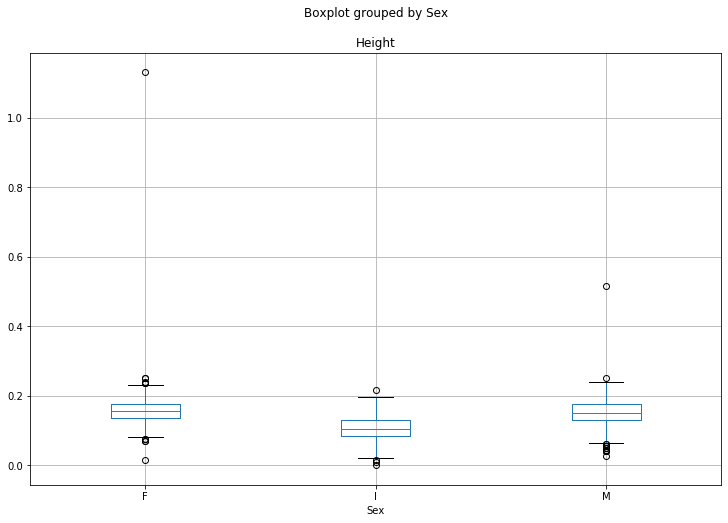

In [0]:
df.boxplot('Height', by='Sex', figsize=(12, 8))

Możemy zauważyć , że najbardziej zbliżone są do siebie płeć męska i żeńska tak jak w przypadku długości Ogólnie mamy też mało obserwacji nietypowych. Jednak najwięcej jest ich dla płci męskiej jak w przypadku długości. Jeżeli będziemy klasyfikować płeć uchowca na podstawie jego długosci to niektóre płci męskie i żeńskie będziemy klasyfikować jako nijakie.

Teraz przeprowadzimy 1 czynnikową analizę wariancji ze wzgledu na pierścień uchowca

In [0]:
groups = pd.unique(df.Sex.values)
data = {g:df['Rings'][df.Sex == g] for g in groups}

k = len(pd.unique(df.Sex))
N = len(df.values)
n1, n2, n3 = df.groupby('Sex').size()

#Anova korzystając z SciPy

from scipy import stats

F, p = stats.f_oneway(data['M'], data['F'], data['I'])

print("F = ",F, "prawdopodobieństwo hipotezy zerowej = ",p)




MultiComp = MultiComparison(df['Rings'],
                            df['Sex'])


print(MultiComp.tukeyhsd(0.01).summary())

F =  369.97385454679113 prawdopodobieństwo hipotezy zerowej =  2.502237830311564e-144
Multiple Comparison of Means - Tukey HSD, FWER=0.01 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     F      I    -3.33  0.001 -3.7221 -2.9379   True
     F      M   -0.354 0.0232 -0.7461  0.0381  False
     I      M    2.976  0.001  2.5839  3.3681   True
----------------------------------------------------


Mimo tak dużego poziomu ufności widać, że możemy odrzucić hipotezę, że średnie są równe między sobą. Oznacza to, że Wysokość uchowca doskonale określa płeć uchowca. Zauważmy jednak, że nie mozemy odrzucić hipotezy alternatywnej na korzyść hipotezy zerowej w przypadku porównania średniej dla płci męskiej i żeńskiej. Poniżej model pudełkowy:

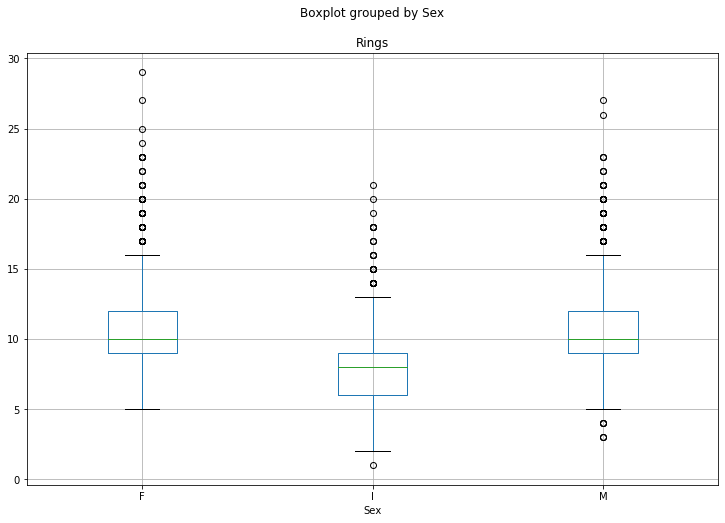

In [0]:
df.boxplot('Rings', by='Sex', figsize=(12, 8))

Możemy zauważyć, że najbardziej zbliżone są do siebie płeć męska i żeńska, co może tłumaczyć, że nie nie możemy odrzucić hipotezy zerowej na korzyść hipotezy alternatywnej. Mamy tez trochę wartosci nietypowych jednak są one równomierne dla każdej płci.